In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor

from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

import scipy.stats as stats

In [3]:
df = pd.read_csv('stock fundamental data.csv')
df.head()
len(df)

50560

# Preprocessing data


In [4]:
# check for any null values in market value 
df.isnull().sum()

gvkey          0
tic            0
fyear         51
indfmt         0
consol         0
popsrc         0
datafmt        0
curcd         51
act        21788
ap         10863
at          6722
ceq         6843
che        13777
cogs       13868
dlc         7086
dlcch      31465
dltt        6884
dp          9347
dvc         7149
ib          6821
intan       7427
invt       12160
ivao       15275
lct        21720
lt          6792
nopio      17628
ppent       8714
rect       14032
sale       13865
spi         7300
txp        15200
txt         6826
xad        35615
xido        6821
xint       12512
xrd        31021
xsga       19673
costat         0
mkvalt     14697
dtype: int64

In [5]:
#create column 'future mkvalt' that holds the market value of the next year
condition1 = df['tic'].shift(-1) == df['tic']
condition2 = df['fyear'].shift(-1) == df['fyear'] + 1
df['future_mkvalt'] = np.where(condition1 & condition2, df['mkvalt'].shift(-1), np.nan)

#drop nulls
df = df.dropna(subset=['mkvalt', 'future_mkvalt'], how='all')

#percent change is the percent change in market value from one year to the next
df['percent_change'] = (df['future_mkvalt']-df['mkvalt'])/df['mkvalt']

#if percent change is greater than 10%, classify as undervalued
df['undervalued'] = (df['percent_change'] > 0.10)

In [6]:
#fill null expenses with 0
df['xrd'] = df['xrd'].fillna(0)
df['xad'] = df['xad'].fillna(0)
df['xsga'] = df['xsga'].fillna(0)
df['xint'] = df['xint'].fillna(0)
df['dlcch'] = df['dlcch'].fillna(0)



#combine all expenses columns into one column
expenses_list = ['xrd', 'xad', 'xsga', 'xint', 'nopio', 'cogs']
df['expenses'] = df[expenses_list].sum(axis=1)

df = df.drop(columns=expenses_list)

#delete duplicate rows due to formatting
condition = df['indfmt'] != "FS"
df = df[condition]

#drop unneccessary columns
df = df.drop(columns=['indfmt', 'consol', 'popsrc', 'datafmt', 'curcd', 'gvkey', 'costat'])




In [7]:
#remove rows with null values
condition = df.isnull().sum(axis=1) < 1
df = df[condition]

In [8]:
df.head()

,tic,fyear,act,ap,at,ceq,che,dlc,dlcch,dltt,...,sale,spi,txp,txt,xido,mkvalt,future_mkvalt,percent_change,undervalued,expenses
0,AIR,2009.0,863.429,114.906,1501.042,746.906,79.370,100.833,-4.996,336.191,...,1352.151,-4.302,3.263,20.986,0.000,777.8348,1049.8206,0.349670,True,1243.600
1,AIR,2010.0,913.985,185.096,1703.727,835.845,57.433,114.075,54.991,329.802,...,1775.782,-1.536,0.000,35.364,-3.313,1049.8206,485.2897,-0.537740,False,1613.484
2,AIR,2011.0,1063.272,201.405,2195.653,864.649,67.720,122.865,0.000,669.489,...,2074.498,-13.864,0.000,25.480,0.000,485.2897,790.0029,0.627900,True,1891.119
3,AIR,2012.0,1033.700,149.300,2136.900,918.600,75.300,86.400,0.000,622.200,...,2167.100,-21.100,0.000,26.700,0.000,790.0029,961.3080,0.216841,True,1970.300
4,AIR,2013.0,1116.900,171.100,2199.500,999.500,89.200,69.700,10.000,564.300,...,2035.000,0.000,0.000,32.100,0.000,961.3080,1046.3954,0.088512,False,1824.100


In [9]:
# check for any null values
df.isnull().sum()

tic               0
fyear             0
act               0
ap                0
at                0
ceq               0
che               0
dlc               0
dlcch             0
dltt              0
dp                0
dvc               0
ib                0
intan             0
invt              0
ivao              0
lct               0
lt                0
ppent             0
rect              0
sale              0
spi               0
txp               0
txt               0
xido              0
mkvalt            0
future_mkvalt     0
percent_change    0
undervalued       0
expenses          0
dtype: int64

In [10]:
# new length of df after processing
len(df)

18538

# remove outliers

In [233]:
original_columns = df.columns

In [234]:
target_cols = list(df.drop(columns = ["fyear", "undervalued","tic","percent_change"]).columns)

z_score_cols = []

# Loop through our target columns
for col in target_cols:
    # Make the new column name the same as the original but with 'z_score' added to it
    new_col_name = col + "_zscore"
    
    # Set the new column equal to the score
    df[new_col_name] = stats.zscore( df[col] )
    
    # Set the z-score to its absolute value of the for easier filtering
    df[new_col_name] = abs( df[new_col_name] )
    
    # Append the new column name our our z_score_cols list for easier access for later.
    z_score_cols.append(new_col_name)


condition = df[z_score_cols] < 3
print(df.shape)

# # Say TRUE only if all of the rows are True, else return False
condition = condition.all(axis=1)

print('Before removal of outliers', df.shape)

df = df[condition]

print('After removal of outliers', df.shape)

(17146, 56)
Before removal of outliers (17146, 56)
After removal of outliers (16144, 56)


In [235]:
#keep original columns only
df = df[original_columns]
len(df)

16144

Text(0.5, 0, 'Percent Increase in market value over 1 year period')

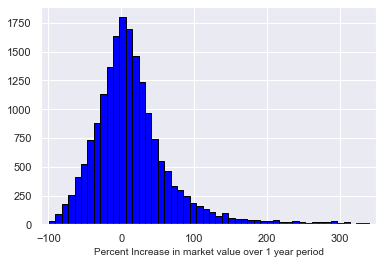

In [11]:
binwidth=0.1
    
# Set up the plot
plot = plt.subplot(1, 1, 1 )
    
# Draw the plot
plot.hist(df['percent_change']*100, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
plt.xlim(-110, 350)
plot.set_xlabel('Percent Increase in market value over 1 year period', size = 10)

In [12]:
#remove outliers
condition1 = df['percent_change'] < 1

#reset indices of dataframe
df = df[condition1].reset_index()

Text(0.5, 0, 'Percent Increase in market value over 1 year period')

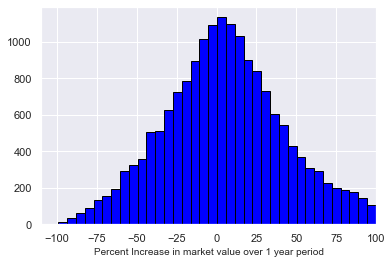

In [13]:
#replot
binwidth=5
    
# Set up the plot
plot = plt.subplot(1, 1, 1 )
plot.hist(df['percent_change']*100, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
#Title and labels
plt.xlim(-110, 100)
plot.set_xlabel('Percent Increase in market value over 1 year period', size = 10)

# Feature engineering

In [14]:
df = df.drop(columns =['index'])
df.head(20)

,tic,fyear,act,ap,at,ceq,che,dlc,dlcch,dltt,...,sale,spi,txp,txt,xido,mkvalt,future_mkvalt,percent_change,undervalued,expenses
0,AIR,2009.0,863.429,114.906,1501.042,746.906,79.370,100.833,-4.996,336.191,...,1352.151,-4.302,3.263,20.986,0.000,777.8348,1049.8206,0.349670,True,1243.600
1,AIR,2010.0,913.985,185.096,1703.727,835.845,57.433,114.075,54.991,329.802,...,1775.782,-1.536,0.000,35.364,-3.313,1049.8206,485.2897,-0.537740,False,1613.484
2,AIR,2011.0,1063.272,201.405,2195.653,864.649,67.720,122.865,0.000,669.489,...,2074.498,-13.864,0.000,25.480,0.000,485.2897,790.0029,0.627900,True,1891.119
3,AIR,2012.0,1033.700,149.300,2136.900,918.600,75.300,86.400,0.000,622.200,...,2167.100,-21.100,0.000,26.700,0.000,790.0029,961.3080,0.216841,True,1970.300
4,AIR,2013.0,1116.900,171.100,2199.500,999.500,89.200,69.700,10.000,564.300,...,2035.000,0.000,0.000,32.100,0.000,961.3080,1046.3954,0.088512,False,1824.100
5,AIR,2014.0,954.100,142.300,1515.000,845.100,54.700,69.000,-80.000,85.000,...,1594.300,-48.400,0.000,-28.500,64.700,1046.3954,842.5112,-0.194844,False,1537.300
6,AIR,2015.0,873.100,163.400,1442.100,865.800,31.200,12.000,60.000,136.100,...,1662.600,-0.400,1.100,18.800,7.200,842.5112,1200.3288,0.424704,True,1531.800
7,AIR,2016.0,888.500,177.400,1504.100,914.200,10.300,2.000,21.000,155.300,...,1767.600,2.600,12.300,24.100,6.300,1200.3288,1551.4580,0.292528,True,1624.700
8,AIR,2017.0,942.700,170.000,1524.700,936.300,41.600,0.000,-1.000,177.200,...,1748.300,0.000,0.000,3.500,-58.100,1551.4580,1046.7709,-0.325299,False,1628.900
9,AAL,2014.0,12112.000,1377.000,43771.000,2021.000,8077.000,1708.000,0.000,16196.000,...,42650.000,-956.000,0.000,330.000,0.000,37405.5843,26452.7417,-0.292813,False,37059.000


In [15]:
#feature selection 
from sklearn.feature_selection import SelectKBest, f_classif,f_regression

# selected features and predict value
Features = list(df.drop(columns=['tic', 'fyear', 'undervalued','percent_change','future_mkvalt']).columns)
X = df[Features]
y = df['future_mkvalt']

#find best features
fs = SelectKBest(score_func=f_regression)

X_selected = fs.fit_transform(X,y)

In [16]:
# best features according to pearson test 
selected_features = fs.get_feature_names_out()
X = df[selected_features]
print(selected_features)

['act' 'at' 'ceq' 'che' 'dp' 'dvc' 'ib' 'lct' 'lt' 'mkvalt']


In [17]:
#print values of the features
fs.scores_

array([3.73457375e+04, 7.36457222e+03, 2.42191650e+04, 2.60811445e+04,
       2.96071245e+04, 4.36701394e+03, 7.91020421e+00, 8.60951883e+03,
       1.17489656e+04, 1.95125909e+04, 2.78053866e+04, 6.79249692e+03,
       3.35680561e+03, 4.12076310e+03, 1.82364480e+04, 1.52848687e+04,
       4.86567380e+03, 1.13985541e+04, 1.01542718e+04, 1.04780012e+03,
       4.82440048e+03, 1.14118974e+04, 9.12846792e+01, 4.23990772e+05,
       8.60000637e+03])

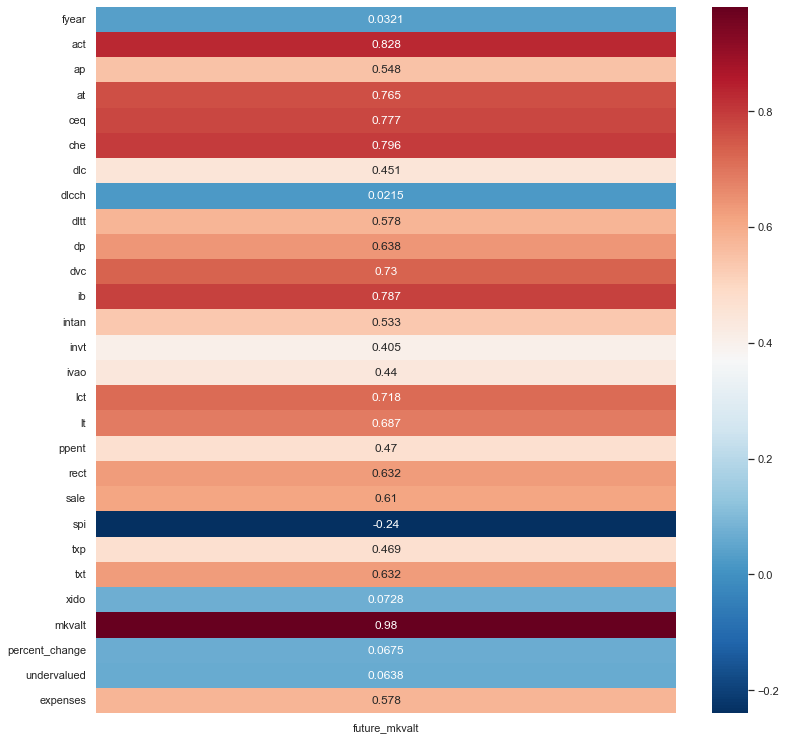

In [18]:
#create heatmap showing which values correlate most with undervalued helps select features

def create_corr_matrix(column_name):
    corr_mat = df.corr()

    corr_targ = corr_mat[[column_name]].drop(labels=[column_name])
    fig, ax = plt.subplots(figsize = (13,13))
    sns.heatmap(corr_targ, annot= True, fmt='.3',cmap='RdBu_r')
    plt.show()
    

create_corr_matrix("future_mkvalt")

# Model building and evaluation

In [20]:
# build pipline which evaluates models 
def build_and_eval_regression_model(model,X,y):
    print("running model report",model)
    
    X_train = X.iloc[3800:]
    X_test = X.iloc[:3800]
    y_train = y.iloc[3800:]
    y_test = y.iloc[:3800]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled,y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    r_squared = metrics.r2_score(y_test,y_pred)
    print("R-squared score:",r_squared)
    
    mea = metrics.mean_absolute_error(y_test,y_pred)
    print("\nMean Absolute Error:",mea)
    
    mse = metrics.mean_squared_error(y_test,y_pred)
    
    print("\nMean squared Error:",mse)

def build_and_eval_classification_model(model,X,y):
    print("running model report",model)
    X_train = X.iloc[3800:]
    X_test = X.iloc[:3800]
    y_train = y.iloc[3800:]
    y_test = y.iloc[:3800]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled,y_train)
    
    model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test,y_pred)
    print("\nAccuracy Score: %f" % accuracy)

    precision = precision_score(y_test,y_pred)
    print("Precision Score: %f" % precision)

    recall = recall_score(y_test,y_pred)
    print("Recall Score: %f" % recall)

    f1 = f1_score(y_test,y_pred)
    print('F1 Score: %f' % f1)

    # Calculate predicted probabilities
    y_pred_proba = model.predict_proba(X_test)

    # Keep only the proba for True
    y_pred_proba = y_pred_proba[:,1]

    # Compute auc score
    auc = roc_auc_score(y_true = y_test, y_score = y_pred_proba )
    print('AUC Score: %f' % auc)

In [246]:
# choose model and hyperparameters then run a grids search to find best paramaters
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

DT_model = DecisionTreeRegressor()



params = {
        'max_depth': [3,5,7],
        'min_samples_leaf': [5,10, 25],
        'min_samples_split': [8, 10, 12],
        'max_features' : [2,6,8,None]
          }

gs = GridSearchCV(estimator=DT_model,
                      param_grid=params,cv=3,verbose=2,
                      refit=True,return_train_score=False)

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=2, min_samples

[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END max_depth=3, max_features=None, min_samples_leaf=25, min_samples_sp

[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV

[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END max_depth=7, max_features=8, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] 

{'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 25,
 'min_samples_split': 8}

In [21]:
# train model using best parameters then test scores
rf = RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=10,
                           min_samples_split=10, n_estimators=100)
build_and_eval_regression_model(rf,X,y)

running model report RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=10,
                      min_samples_split=10)
R-squared score: 0.9010039161190261

Mean Absolute Error: 3363.073825168736

Mean squared Error: 162475673.35322705


In [22]:
# linear regression
lr = LinearRegression()
build_and_eval_regression_model(lr,X,y)

running model report LinearRegression()
R-squared score: 0.9438018952028705

Mean Absolute Error: 3002.57794304165

Mean squared Error: 92234203.21421112


In [23]:
# Knn Regressor 
k = 3
knnreg = KNeighborsRegressor(n_neighbors= k )
build_and_eval_regression_model(knnreg,X,y)

running model report KNeighborsRegressor(n_neighbors=3)
R-squared score: 0.8233283094455454

Mean Absolute Error: 5128.485169605263

Mean squared Error: 289959468.69777936


In [24]:
#decision tree regressor
dt = gs.best_estimator_
build_and_eval_regression_model(dt,X,y)

NameError: name 'gs' is not defined

In [25]:
#convert predicted percent changes into undervalued or overvalued 

def build_model(model,X,y):
    X_train = X.iloc[3800:]
    X_test = X.iloc[:3800]
    y_train = y.iloc[3800:]
    y_test = y.iloc[:3800]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled,y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    return y_pred
    

def undervalued(prediction):
    percent_change =  (prediction-X_test['mkvalt']) /X_test['mkvalt']
    arr = np.where(percent_change > .10,True,False)
    return arr

In [26]:
# Evaluate and print model scores using accuracy, precision, recall, f1 scores, and auc scores. 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
def test_regression_conversion(model,undervalued_y_test,undervalued_y_pred):
    
    print("running test for model",model)
    accuracy = accuracy_score(undervalued_y_test,undervalued_y_pred)
    print("\nAccuracy Score: %f" % accuracy)

    precision = precision_score(undervalued_y_test,undervalued_y_pred)
    print("Precision Score: %f" % precision)

    recall = recall_score(undervalued_y_test,undervalued_y_pred)
    print("Recall Score: %f" % recall)

    f1 = f1_score(undervalued_y_test,undervalued_y_pred)
    print('F1 Score: %f' % f1)

In [27]:
# y test set turned to true false for testing
y_test = y.iloc[:3800]
undervalued_y_test = undervalued(y_test)

In [31]:
#random forest test
y_pred_rf = build_model(rf,X,y)
undervalued_y_pred_rf = undervalued(y_pred_rf)

test_regression_conversion(rf,undervalued_y_test,undervalued_y_pred_rf)
find_return(rf,y_test,undervalued_y_pred_rf)

running test for model RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=10,
                      min_samples_split=10)

Accuracy Score: 0.511579
Precision Score: 0.443811
Recall Score: 0.317229
F1 Score: 0.369993
return for model RandomForestRegressor(max_depth=7, max_features=None, min_samples_leaf=10,
                      min_samples_split=10)
Initial Investment: 122800
Total Return: [132971.0318626]
Percent increase: [0.08282599]


In [32]:
# linear regression test
y_pred_lr = build_model(lr,X,y)
undervalued_y_pred_lr = undervalued(y_pred_lr)

test_regression_conversion(lr,undervalued_y_test,undervalued_y_pred_lr)
find_return(lr,y_test,undervalued_y_pred_lr)

running test for model LinearRegression()

Accuracy Score: 0.517632
Precision Score: 0.433217
Recall Score: 0.217113
F1 Score: 0.289259
return for model LinearRegression()
Initial Investment: 86100
Total Return: [92195.33188327]
Percent increase: [0.07079363]


In [33]:
# K nearest test
y_pred_kn = build_model(knnreg,X,y)
undervalued_y_pred_kn = undervalued(y_pred_kn)

test_regression_conversion(knnreg,undervalued_y_test,undervalued_y_pred_kn)
find_return(knnreg,y_test,undervalued_y_pred_kn)

running test for model KNeighborsRegressor(n_neighbors=3)

Accuracy Score: 0.519211
Precision Score: 0.467501
Recall Score: 0.456345
F1 Score: 0.461856
return for model KNeighborsRegressor(n_neighbors=3)
Initial Investment: 167700
Total Return: [183361.88741733]
Percent increase: [0.09339229]


In [ ]:
# decision Tree test
y_pred_dt = build_model(dt,X,y)
undervalued_y_pred_dt = undervalued(y_pred_dt)

test_regression_conversion(dt,undervalued_y_test,undervalued_y_pred_dt)
find_return(dt,y_test,undervalued_y_pred_dt)

In [264]:
# find most important features
# feature_imp = pd.DataFrame.from_dict( {'feature_importance': rf_model.feature_importances_,
#                                        'feature':selected_features}).sort_values('feature_importance', ascending=False)
# feature_imp

In [30]:
# find the total return if you would invest in certain companies 
def find_return(model,y_test,undervalued_y_pred):
    undervalued_y_pred = undervalued_y_pred.tolist()
    gains = 0
    investment = 0
    arr = y_test.index
    len(arr)
    for i in range(len(undervalued_y_pred)):
        if(undervalued_y_pred[i]):
            index = arr[i]
            investment = investment + 100
            change = 100  + 100*(df.loc[[index]]['percent_change'].values)
            gains = gains + change
    
    print("return for model",model)
    print('Initial Investment: ' + str(investment))
    print('Total Return: ' + str(gains))
    print('Percent increase: ' + str((gains-investment)/investment))       
